In [1]:
from os.path import exists

import pandas as pd
import numpy as np

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy.io.wavfile import write
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft,rfft, rfftfreq

from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import numpy as np

## Observational data of Sunspots comes from [SilSo](http://www.sidc.be/silso/dayssnplot)

 * SN_d_tot_V2.0.csv
 * SN_ms_tot_V2.0.csv

## Cleaning the data, if needed

In [2]:
if exists('../data/pickled_sunspot_data.pkl'):
    print('Using the data that has already been cleaned.')
else:
    print("Clean data isn't here. Cleaning and exporting.")
    
    sun = pd.read_csv('../data/SN_d_tot_V2.0.csv', sep = ';')
    sun.columns = ['Year', 'Month', 'Day', 'Fractional Date', 'SunSpot Count', "DailyStDev", "Observations", 'Indicator']
    sun['Date'] = sun['Year'].map(str)+ '-' + sun['Month'].map(str) + '-' + sun['Day'].map(str)
    pd.to_datetime(sun['Date'], utc=False)
    
    sun = sun[['Date', 'SunSpot Count', 'DailyStDev', 'Observations', 'Indicator', 'Fractional Date'] ]
    sun['Indicator'] = sun['Indicator'].astype(bool)
    
    sun[['Observations', 'SunSpot Count']] = sun[['Observations', 'SunSpot Count']].astype(int)
    sun.to_pickle('../data/pickled_sunspot_data.pkl')

Using the data that has already been cleaned.


In [3]:
sun = pd.read_pickle('../data/pickled_sunspot_data.pkl')
sun.head()

,Date,SunSpot Count,DailyStDev,Observations,Indicator,Fractional Date
0,1818-1-2,-1,-1.0,0,True,1818.004
1,1818-1-3,-1,-1.0,0,True,1818.007
2,1818-1-4,-1,-1.0,0,True,1818.010
3,1818-1-5,-1,-1.0,0,True,1818.012
4,1818-1-6,-1,-1.0,0,True,1818.015


## Initial plots

Hundreds of Sunspots in a day seem suspicous until you check above and see `SunSpot Count` column, `max` row.<br> But I don't know why part of the chart is white.

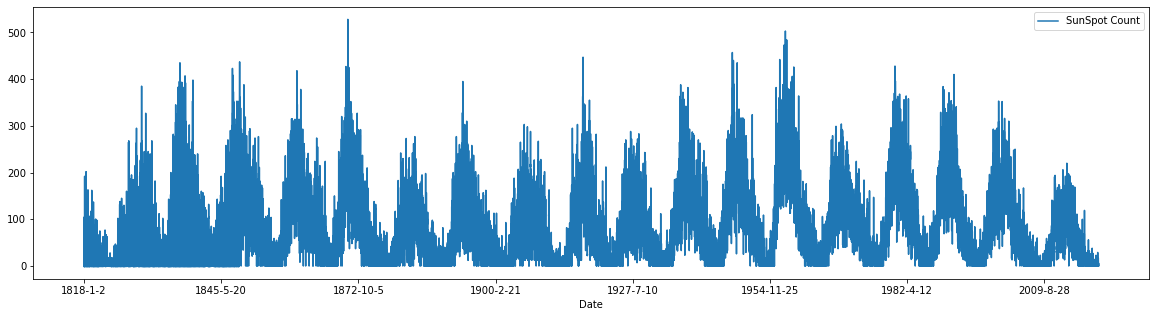

In [4]:
plt.figure(figsize = (20, 5))
ax = plt.gca()

sun.plot(kind='line', x='Date', y='SunSpot Count', ax=ax)
plt.show()

this look like there are mulitiple periods. One seems to be about 110 years or so and there is another that seems to be may 12 or so years. But there is probably 2-3 other cycles. In terms of explaining things, being able to show those periods would be a good start.

So lets start with a couple of moving averages on one chart

In [5]:
window = 730 #makes for a two year rolling average
sun['2yr'] = sun.iloc[:,1].rolling(window=730).mean()
sun['20yr'] = sun.iloc[:,1].rolling(window=7300).mean()

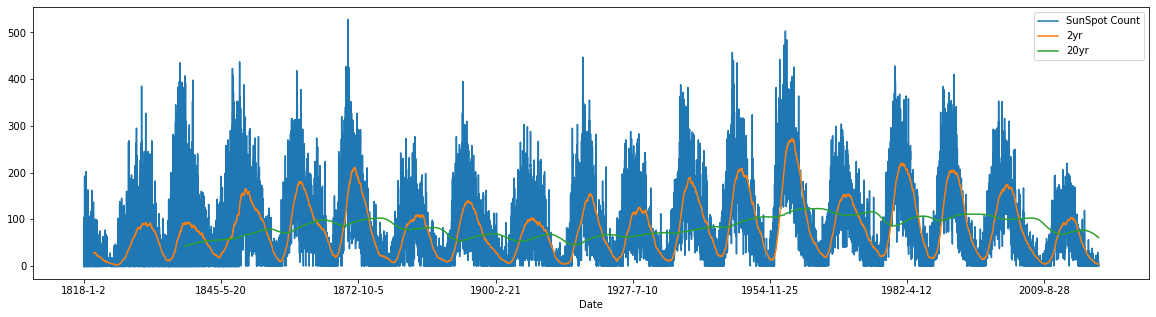

In [6]:
plt.figure(figsize = (20, 5))
ax = plt.gca()

sun.plot(kind='line', x='Date', y='SunSpot Count', ax=ax)
sun.plot(kind='line', x='Date', y='2yr', ax=ax)
sun.plot(kind='line', x='Date', y='20yr', ax=ax)
plt.show()

# temperature = df['temp']
# t_average = temperature.rolling(window=7).mean()

This is closer but I think it would be better if the lines were darker and were closer the the max values. But that seems to be a minor point so that me be better left for later.

Moving on; it's time to break down the wave down. Some sort of time series analysis like an ARIMA but I want to also look at what a fast fourier transformation (FFT) could do.

It's been a while so a refresher on how FFT works would be useful

So, starting with FFT

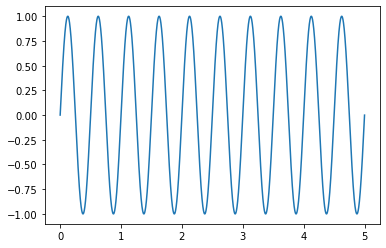

In [7]:
SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()

In [8]:
_, nice_tone = generate_sine_wave(400, SAMPLE_RATE, DURATION)
_, noise_tone = generate_sine_wave(4000, SAMPLE_RATE, DURATION)
noise_tone = noise_tone * 0.3

mixed_tone = nice_tone + noise_tone

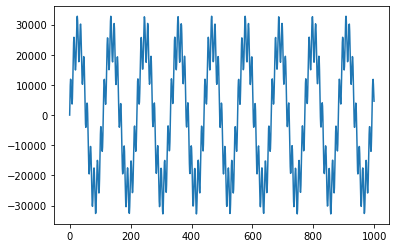

In [9]:
normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 32767)

plt.plot(normalized_tone[:1000])
plt.show()

In [10]:
# Remember SAMPLE_RATE = 44100 Hz is our playback rate
write("mysinewave.wav", SAMPLE_RATE, normalized_tone)


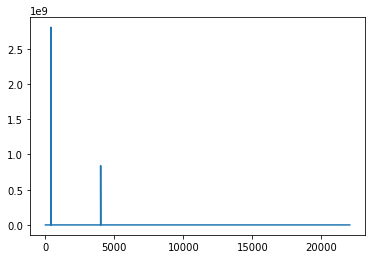

In [11]:
# Note the extra 'r' at the front
yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))


plt.show()

### This is nice but i really would like those spikes to be labeled with the value at x (the freq)

In [12]:
yf.size

220500

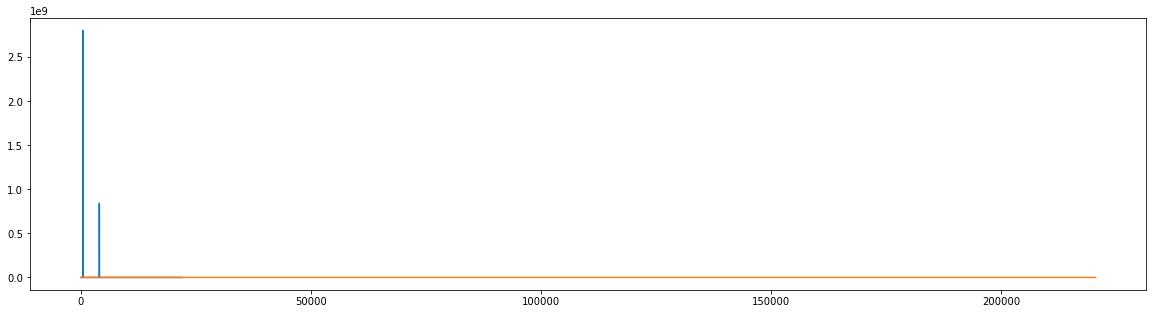

In [13]:
# Note the extra 'r' at the front
plt.figure(figsize = (20, 5))

yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)
peaks, _ = find_peaks(x, distance=1000)
plt.plot(xf, np.abs(yf))


c= np.diff(peaks)

plt.plot(x)
plt.plot(peaks, x[peaks], 'x')
plt.show()

### Let's take a step back an use find_peaks to see if I can get that to lablel the values.
### I'm using the find_peaks and using the electrocardiogram dataset 

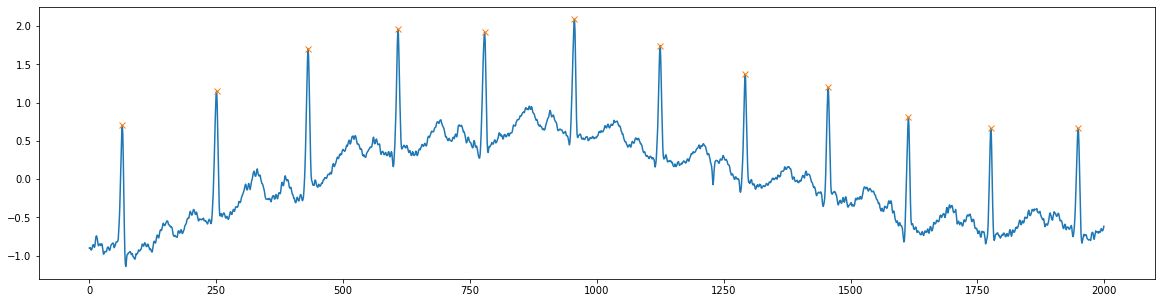

array([186, 180, 177, 171, 177, 169, 167, 164, 158, 162, 172])

In [14]:
plt.figure(figsize = (20, 5))

x = electrocardiogram()[2000:4000]

peaks, _ = find_peaks(x, distance=150)

c= np.diff(peaks)

plt.plot(x)
plt.plot(peaks, x[peaks], 'x')
plt.show()
c

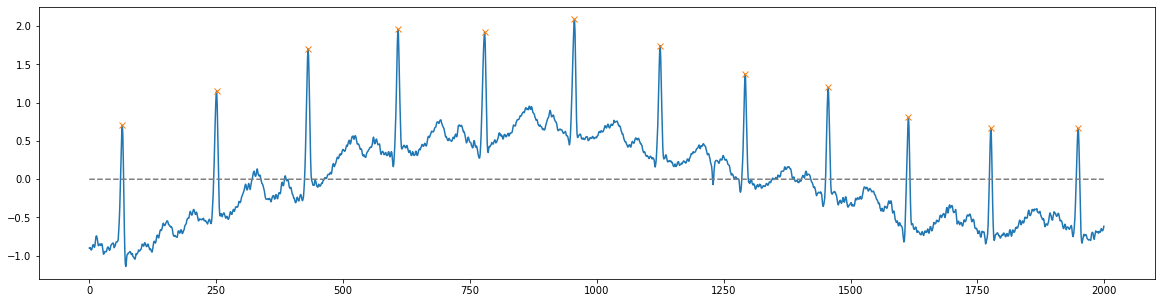

In [15]:
plt.figure(figsize = (20, 5))
x = electrocardiogram()[2000:4000]
peaks, _ = find_peaks(x, height=0, distance=100)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [16]:
p, q = peaks, x[peaks]

peaks, _ = find_peaks(x, distance=150)
np.diff(peaks)

array([186, 180, 177, 171, 177, 169, 167, 164, 158, 162, 172])

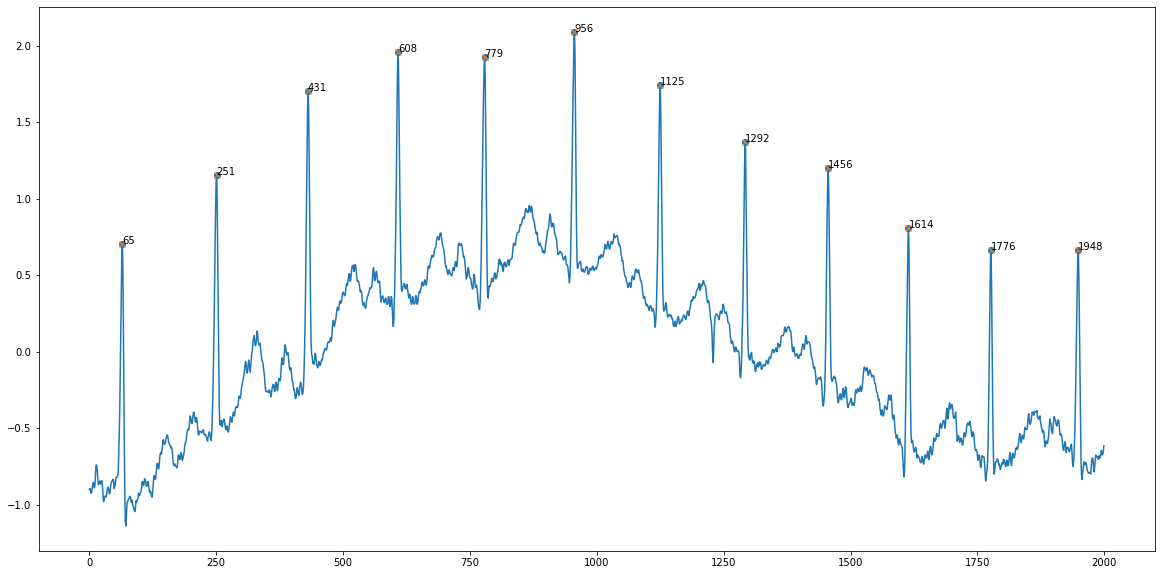

In [17]:
fig, ax = plt.subplots()
ax.scatter(p, q)
plt.gcf().set_size_inches(20, 10)
for i, txt in enumerate(p):
    ax.annotate(txt, (p[i], q[i]))

plt.plot(x)
plt.plot(peaks, x[peaks], 'x')

plt.show()

In [18]:
fft = np.fft.fft(sun['SunSpot Count'])

for i in range(2):
    print("Value at index {}:\t{}".format(i, fft[i + 1]), "\nValue at index {}:\t{}".format(fft.size -1 - i, fft[-1 - i]))

Value at index 0:	(-224722.57478481994+628036.5258862108j) 
Value at index 73959:	(-224722.57478481997-628036.5258862107j)
Value at index 1:	(-917885.0689059759-232011.06237980953j) 
Value at index 73958:	(-917885.0689059759+232011.0623798095j)


### Next step --

 1. Take the numbers from `cell 29` and adapt the code to display the frequencies in `cell 24` and `cell 17`
 2. That should allow me to see the frequencies in the test case. Might need a periodic filter to take out the non-peaks
 3. That souuld give me a start on finding the freqs for the `sun` dataset